# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

In [113]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg
from geopy.geocoders import Nominatim
import osmnx as ox

In [4]:
df_origins = pd.read_csv('data/origins.csv')
df_destinations = pd.read_csv('data/destinations.csv')

In [11]:
df_origins['geom'] = df_origins.apply(lambda row: sg.Point([row['x'], row['y']]), axis = 1)
df_destinations['geom'] = df_destinations.apply(lambda row: sg.Point([row['x'], row['y']]), axis = 1)

In [22]:
gdf_origins = gpd.GeoDataFrame({'id': df_origins.index.values, 'geometry':df_origins['geom']}, geometry = 'geometry')
gdf_origins = gdf_origins.set_crs(4326)
gdf_destinations = gpd.GeoDataFrame({'id': df_destinations.index.values, 'geometry':df_destinations['geom']}, geometry = 'geometry')
gdf_destinations = gdf_destinations.set_crs(4326)

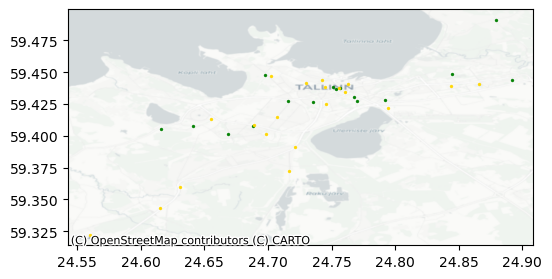

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
gdf_origins.plot(ax = ax, color = 'green', markersize = 2, alpha = 0.9, zorder = 3)
gdf_destinations.plot(ax = ax, color = 'gold', markersize = 2, alpha = 0.9, zorder = 3)
ctx.add_basemap(ax = ax, crs = gdf_origins.crs, source = ctx.providers.CartoDB.Positron)

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation ](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [66]:
geolocator = Nominatim(user_agent='autogis 2023', timeout = 10)
location = geolocator.reverse(df_origins[['y', 'x']].loc[2].to_list())
print(location.raw)

{'place_id': 181323378, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 26920818, 'lat': '59.401768000000004', 'lon': '24.668583250139324', 'class': 'shop', 'type': 'convenience', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'shop', 'name': 'Grossi Toidukaubad', 'display_name': 'Grossi Toidukaubad, 41, Ehitajate tee, Mustamäe, Mustamäe linnaosa, Tallinn, Harju maakond, 12612, Eesti', 'address': {'shop': 'Grossi Toidukaubad', 'house_number': '41', 'road': 'Ehitajate tee', 'quarter': 'Mustamäe', 'suburb': 'Mustamäe linnaosa', 'city': 'Tallinn', 'municipality': 'Tallinn', 'county': 'Harju maakond', 'ISO3166-2-lvl6': 'EE-37', 'postcode': '12612', 'country': 'Eesti', 'country_code': 'ee'}, 'boundingbox': ['59.4016961', '59.4018398', '24.6683574', '24.6688092']}


In [54]:
location = geolocator.geocode("Roma, Italia")

In [60]:
location = geolocator.reverse("59.4018, 24.6686")

**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located** 
- hint: combine the origin and destination points into one layer, and define a convex hull for the combined points
- store the polygon in a variable called `extent`

In [ ]:
# Save points in gdf_origins and gdf_destinations into a list
points_list = []
for i, row in gdf_origins.iterrows():
    points_list.append(row['geometry'])

for i, row in gdf_destinations.iterrows():
    points_list.append(row['geometry'])

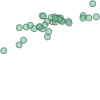

In [101]:
# create a Shapely MultiPoint geometry and retrieve the relative convex_hull (a Polygon)
multi_point_geom = sg.MultiPoint(points_list)
multi_point_geom

In [154]:
#extent = multi_point_geom.convex_hull
#di seguito impostiamo extent come una envelope
extent = multi_point_geom.envelope
type(extent)

shapely.geometry.polygon.Polygon

In [155]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(extent)

POLYGON ((24.5598 59.3224, 24.8921 59.3224, 24.8921 59.4912, 24.5598 59.4912, 24.5598 59.3224))


In [156]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(extent))

<class 'shapely.geometry.polygon.Polygon'>


The 'extent' Polygon must be buffered in order to include the network of nodes and edges a little beyond its boundaries.

therefore we are going to make a GeoDataFrame with the 'extent' geometry, convert the crs to a UTM-like one, buffer its geometry, extract the buffered extent and retrieve data from OSM with that expanded extent.

In [157]:
gdf_extent = gpd.GeoDataFrame({'geometry':[extent]}, geometry = 'geometry')
gdf_extent = gdf_extent.set_crs(4326)

In [158]:
#gdf_extent = gdf_extent.to_crs(32633)

In [159]:
gdf_extent_buffered = gdf_extent.copy().reset_index(drop=True)
gdf_extent_buffered = gdf_extent_buffered.to_crs(32633)
gdf_extent_buffered['geometry'] = gdf_extent_buffered['geometry'].buffer(500)
gdf_extent_buffered = gdf_extent_buffered.to_crs(gdf_extent.crs)

<Axes: >

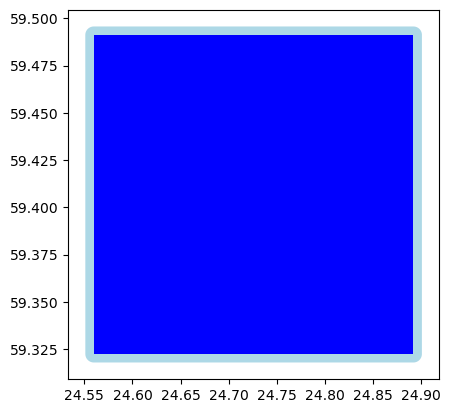

In [160]:
ax = gdf_extent.plot(color = 'blue', zorder = 3)
gdf_extent_buffered.plot(ax = ax, color='lightblue')

- Use the polygon to fetch the network data with `.graph_from_polygon()` function 
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

In [161]:
graph = ox.graph_from_polygon(gdf_extent_buffered.at[0, 'geometry'], network_type = 'drive')

In [162]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [163]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 74726 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

21282


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

In [164]:
nodes, edges = ox.graph_to_gdfs(graph)

In [165]:
utm_common_proj_meters = 'EPSG:32633'
gdf_origins = gdf_origins.to_crs(utm_common_proj_meters)
gdf_destinations = gdf_destinations.to_crs(utm_common_proj_meters)
nodes = nodes.to_crs(utm_common_proj_meters)
edges = edges.to_crs(utm_common_proj_meters)

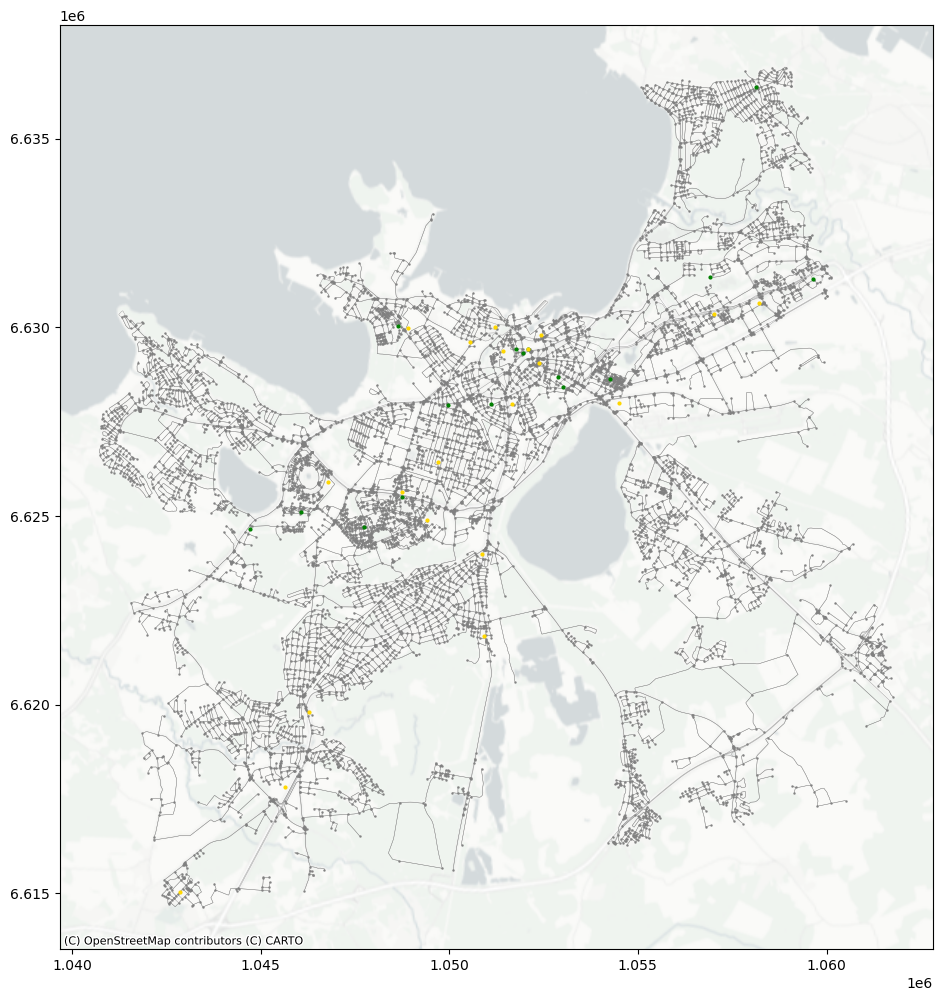

In [166]:
fig, ax = plt.subplots(figsize=(12,12))
gdf_origins.plot(ax = ax, color = 'green', markersize = 4, alpha = 1, zorder = 4)
gdf_destinations.plot(ax = ax, color = 'gold', markersize = 4, alpha = 1, zorder = 4)
nodes.plot(ax = ax, color = 'grey', markersize = 0.6, alpha = 0.9, zorder = 3)
edges.plot(ax = ax, color = 'grey', linewidth = 0.3, alpha = 0.8, zorder = 2)
ctx.add_basemap(ax = ax, crs = gdf_origins.crs, source = ctx.providers.CartoDB.PositronNoLabels)

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [ ]:
# Store the shortest path routes as LineString geometries in a GeoDataFrame called routes:
routes = None

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [ ]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

In [ ]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

In [ ]:
# NON-EDITABLE TEST CELL
print("Longest distance:", round(routes['route_dist'].max()), "meters")

**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

In [ ]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [ ]:
total_distance = 0

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

In [ ]:
# NON-EDITABLE TEST CELL
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)